<a href="https://colab.research.google.com/github/sedaoturak/dcgan_cahn-hilliard/blob/main/DCGAN_Cahn_Hillard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

import os
try:
	from google.colab import drive
	IN_COLAB = True
	drive.mount('/content/drive')
	PATH = '/content/drive/MyDrive/Colab Notebooks/' # change this with your drive's path
except:
	IN_COLAB = False
	PATH = os.getcwd()[:-9]

Mounted at /content/drive


# Load data

In [2]:
# define the directory to dataset (the folder having the bitmap images and their strain energy values in text files
with open(PATH+'Case1_input_patterns_64_x_64.txt', 'r') as f:
  g = np.loadtxt(f)
with open(PATH+'Case1_strain_energy.txt', 'r') as f:
  e = np.loadtxt(f)

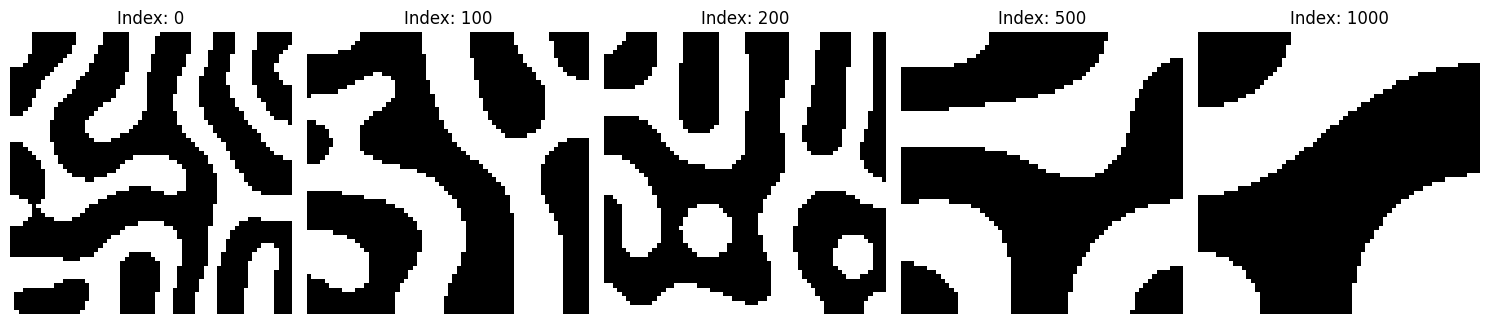

In [3]:
# visualize an image from dataset
img = g.reshape(37523,64,64) # reshape image dataset so that you'll get (number of images, first dimension, second dimension)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate([0, 100, 200, 500, 1000]): #random indices of five images
    axes[i].imshow(img[idx, :, :], interpolation='nearest', cmap='binary')
    axes[i].set_title(f"Index: {idx}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Preprocessing

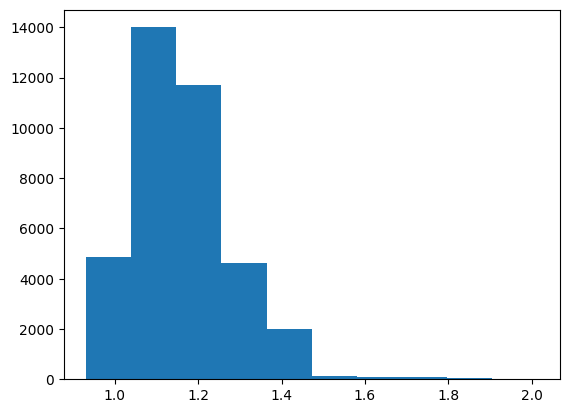

In [ ]:
# visualize the distribution of the output (energy) values
# maximum energy (at the last index) is considered

fig, ax = plt.subplots()
ax.hist(e[:,-1])
plt.show()

In [4]:
# apply different preprocessing on the strain energy values to compare
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# normalization
scaler = MinMaxScaler(feature_range=(0,1))
e_scaled = scaler.fit_transform(e[:,-1].reshape(-1, 1))

# power transformation
pt = PowerTransformer()
e_power = pt.fit_transform(e[:,-1].reshape(-1, 1))

# power transformation + normalization
scaler = MinMaxScaler(feature_range=(0,1))
e_power_scaled = scaler.fit_transform(e_power)

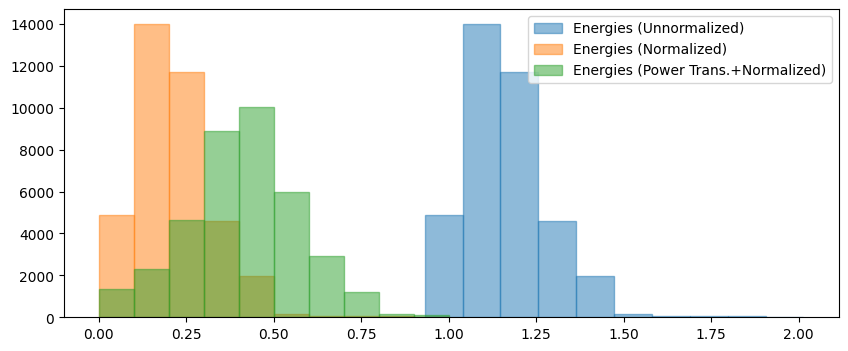

In [ ]:
fig, axs = plt.subplots(figsize=(10,4))

axs.hist(e[:,-1], label=f'Energies (Unnormalized)', alpha=0.5, edgecolor='tab:blue', linewidth=1)
axs.hist(e_scaled, label=f'Energies (Normalized)', alpha=0.5, edgecolor='tab:orange', linewidth=1)
# axs.hist(e_power, label=f'Energies (Power Trans.)', alpha=0.5, edgecolor='tab:red', linewidth=1)
axs.hist(e_power_scaled, label=f'Energies (Power Trans.+Normalized)', alpha=0.5, edgecolor='tab:green', linewidth=1)
axs.legend()
plt.show()

In [13]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        # Normalize images to [-1, 1] for DCGAN Tanh output
        self.images = (torch.tensor(images, dtype=torch.float32).unsqueeze(1) / 0.5) - 1.0
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

images = g.reshape((37523,64,64))
energies = e_power_scaled.ravel()

# unpack to batch, width, height
b, w, h, = [*images.shape]
print(images.shape)

# add a channel dimension
images_wb = np.repeat(images[..., np.newaxis], 1, -1)
print(images_wb.shape)

# prepare images for neural network with the shape of (Batch, Channels, Width, Height)
images_wb = images_wb.reshape(b, 1, w, h)
print(images_wb.shape)

dataset = CustomDataset(images, energies)

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

# train-test split ---
train_set_size = int(len(dataset) * 0.8)
val_set_size = int((len(dataset) - train_set_size)/2)
test_set_size = len(dataset) - (train_set_size + val_set_size)

trainset, valset, testset = random_split(dataset, [train_set_size, val_set_size, test_set_size])

batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

(37523, 64, 64)
(37523, 64, 64, 1)
(37523, 1, 64, 64)


# Model

In [14]:
# Generator Network
class Generator(nn.Module):
    """
    DCGAN Generator for 64x64 microstructure images
    """
    def __init__(self, latent_dim=100, ngf=64, use_dropout=True):
        """
        Args:
            latent_dim: Dimension of latent noise vector
            ngf: Number of generator filters in first conv layer
            use_dropout: Use dropout in generator
        """
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.Dropout(0.2) if use_dropout else nn.Identity(),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Dropout(0.2) if use_dropout else nn.Identity(),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# Discriminator Network
class Discriminator(nn.Module):
    """
    DCGAN Discriminator for 64x64 microstructure images
    """
    def __init__(self, ndf=64, use_dropout=True):
        """
        Args:
            ndf: Number of discriminator filters in first conv layer
        """
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Input: 1 x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3) if use_dropout else nn.Identity(),
            # State: ndf x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3) if use_dropout else nn.Identity(),
            # State: (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3) if use_dropout else nn.Identity(),
            # State: (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)

# Weight Initialization
def weights_init(m):
    """
    Custom weights initialization (DCGAN paper)
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def add_instance_noise(images, std=0.1):
    """
    Add noise to discriminator inputs to prevent overfitting
    """
    noise = torch.randn_like(images) * std
    return images + noise

# Training

In [15]:
# Data parameters
IMAGE_SIZE = 64

# Training parameters
BATCH_SIZE = 64        # Smaller batch for small dataset
LATENT_DIM = 100

# Improved learning rates (prevents discriminator dominance)
LEARNING_RATE_G = 0.0002
LEARNING_RATE_D = 0.00003  # 6.6x slower than generator
BETA1 = 0.5
BETA2 = 0.999

# Training balance
D_TRAIN_STEPS = 1      # Train discriminator once per batch
G_TRAIN_STEPS = 4      # Train generator THREE times per batch

# Regularization
REAL_LABEL_SMOOTH = 0.9    # Label smoothing for real images
FAKE_LABEL_SMOOTH = 0.1    # Occasional label flipping
INSTANCE_NOISE_STD = 0.12  # Instance noise strength

# Other settings
NUM_WORKERS = 2 if IN_COLAB else 4

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
generator = Generator(latent_dim=LATENT_DIM, use_dropout=True).to(device)
discriminator = Discriminator(use_dropout=True).to(device)

# Apply weight initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

# Loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, BETA2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=(BETA1, BETA2))

# Training history
history = {
    'train_g_loss': [],
    'train_d_loss': [],
    'val_g_loss': [],
    'val_d_loss': [],
    'd_real_acc': [],
    'd_fake_acc': []
}

# Store some real samples for comparison
real_samples_for_comparison = []
for images, _ in trainloader:
    real_samples_for_comparison = images[:5].cpu()
    break

print('Models initialized')
print(f'Generator parameters: {sum(p.numel() for p in generator.parameters()):,}')
print(f'Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}')

def validate(generator, discriminator, val_loader, criterion, device):
    """Compute validation losses"""
    generator.eval()
    discriminator.eval()

    total_g_loss = 0.0
    total_d_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for real_images, _ in val_loader:
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Discriminator loss on real
            real_labels = torch.ones(batch_size, 1, device=device)
            d_real_output = discriminator(real_images)
            d_real_loss = criterion(d_real_output, real_labels)

            # Discriminator loss on fake
            z = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
            fake_images = generator(z)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            d_fake_output = discriminator(fake_images)
            d_fake_loss = criterion(d_fake_output, fake_labels)

            # Generator loss
            g_loss = criterion(d_fake_output, real_labels)

            total_d_loss += (d_real_loss + d_fake_loss).item()
            total_g_loss += g_loss.item()
            num_batches += 1

    generator.train()
    discriminator.train()

    return total_g_loss / num_batches, total_d_loss / num_batches

Models initialized
Generator parameters: 3,574,656
Discriminator parameters: 2,763,520


In [ ]:
# training loop
NUM_EPOCHS = 50
for epoch in range(1, NUM_EPOCHS + 1):
    # Training phase
    generator.train()
    discriminator.train()

    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    epoch_d_real_correct = 0
    epoch_d_fake_correct = 0
    total_samples = 0

    for real_images, _ in tqdm(trainloader, desc=f'Epoch {epoch}/{NUM_EPOCHS}', leave=False):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        total_samples += batch_size

        # Train Discriminator
        for _ in range(D_TRAIN_STEPS):
            d_optimizer.zero_grad()

            # Real images with noise and label smoothing
            real_noisy = add_instance_noise(real_images, INSTANCE_NOISE_STD)
            real_labels = torch.ones(batch_size, 1, device=device) * REAL_LABEL_SMOOTH
            d_real_out = discriminator(real_noisy)
            d_real_loss = criterion(d_real_out, real_labels)

            # Fake images
            z = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
            fake_images = generator(z)
            fake_noisy = add_instance_noise(fake_images.detach(), INSTANCE_NOISE_STD)

            if np.random.random() < 0.05:
                fake_labels = torch.ones(batch_size, 1, device=device) * FAKE_LABEL_SMOOTH
            else:
                fake_labels = torch.zeros(batch_size, 1, device=device) + FAKE_LABEL_SMOOTH

            d_fake_out = discriminator(fake_noisy)
            d_fake_loss = criterion(d_fake_out, fake_labels)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            epoch_d_real_correct += (d_real_out > 0.5).sum().item()
            epoch_d_fake_correct += (d_fake_out < 0.5).sum().item()

        # Train Generator
        for _ in range(G_TRAIN_STEPS):
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
            fake_images = generator(z)
            d_fake_out = discriminator(fake_images)
            real_labels = torch.ones(batch_size, 1, device=device)
            g_loss = criterion(d_fake_out, real_labels)
            g_loss.backward()
            g_optimizer.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    # Calculate training metrics
    avg_train_g_loss = epoch_g_loss / len(trainloader)
    avg_train_d_loss = epoch_d_loss / len(trainloader)
    avg_d_real_acc = epoch_d_real_correct / (total_samples * D_TRAIN_STEPS)
    avg_d_fake_acc = epoch_d_fake_correct / (total_samples * D_TRAIN_STEPS)

    # Validation phase
    avg_val_g_loss, avg_val_d_loss = validate(generator, discriminator, valloader, criterion, device)

    # Store history
    history['train_g_loss'].append(avg_train_g_loss)
    history['train_d_loss'].append(avg_train_d_loss)
    history['val_g_loss'].append(avg_val_g_loss)
    history['val_d_loss'].append(avg_val_d_loss)
    history['d_real_acc'].append(avg_d_real_acc)
    history['d_fake_acc'].append(avg_d_fake_acc)

    # Print progress
    print(f'Epoch [{epoch:3d}/{NUM_EPOCHS}] '
          f'Train - G: {avg_train_g_loss:.4f}, D: {avg_train_d_loss:.4f} | '
          f'Val - G: {avg_val_g_loss:.4f}, D: {avg_val_d_loss:.4f} | '
          f'D_acc: R={avg_d_real_acc:.3f}, F={avg_d_fake_acc:.3f}')

    if avg_d_real_acc > 0.95 and avg_d_fake_acc > 0.95:
        print('  ⚠️  WARNING: Discriminator too strong!')

print('\n' + '='*70)
print('Training completed!')
print('='*70)

In [17]:
import csv
# Save model
os.makedirs('models', exist_ok=True)
torch.save({
    'epoch': NUM_EPOCHS,
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
    'g_optimizer': g_optimizer.state_dict(),
    'd_optimizer': d_optimizer.state_dict(),
    'history': history
}, 'models/dcgan_final.pth')

# Save history to CSV
with open('training_history.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train_G_Loss', 'Train_D_Loss', 'Val_G_Loss', 'Val_D_Loss', 'D_Real_Acc', 'D_Fake_Acc'])
    for i in range(len(history['train_g_loss'])):
        writer.writerow([
            i+1,
            history['train_g_loss'][i],
            history['train_d_loss'][i],
            history['val_g_loss'][i],
            history['val_d_loss'][i],
            history['d_real_acc'][i],
            history['d_fake_acc'][i]
        ])

print('Model and history saved!')

Model and history saved!


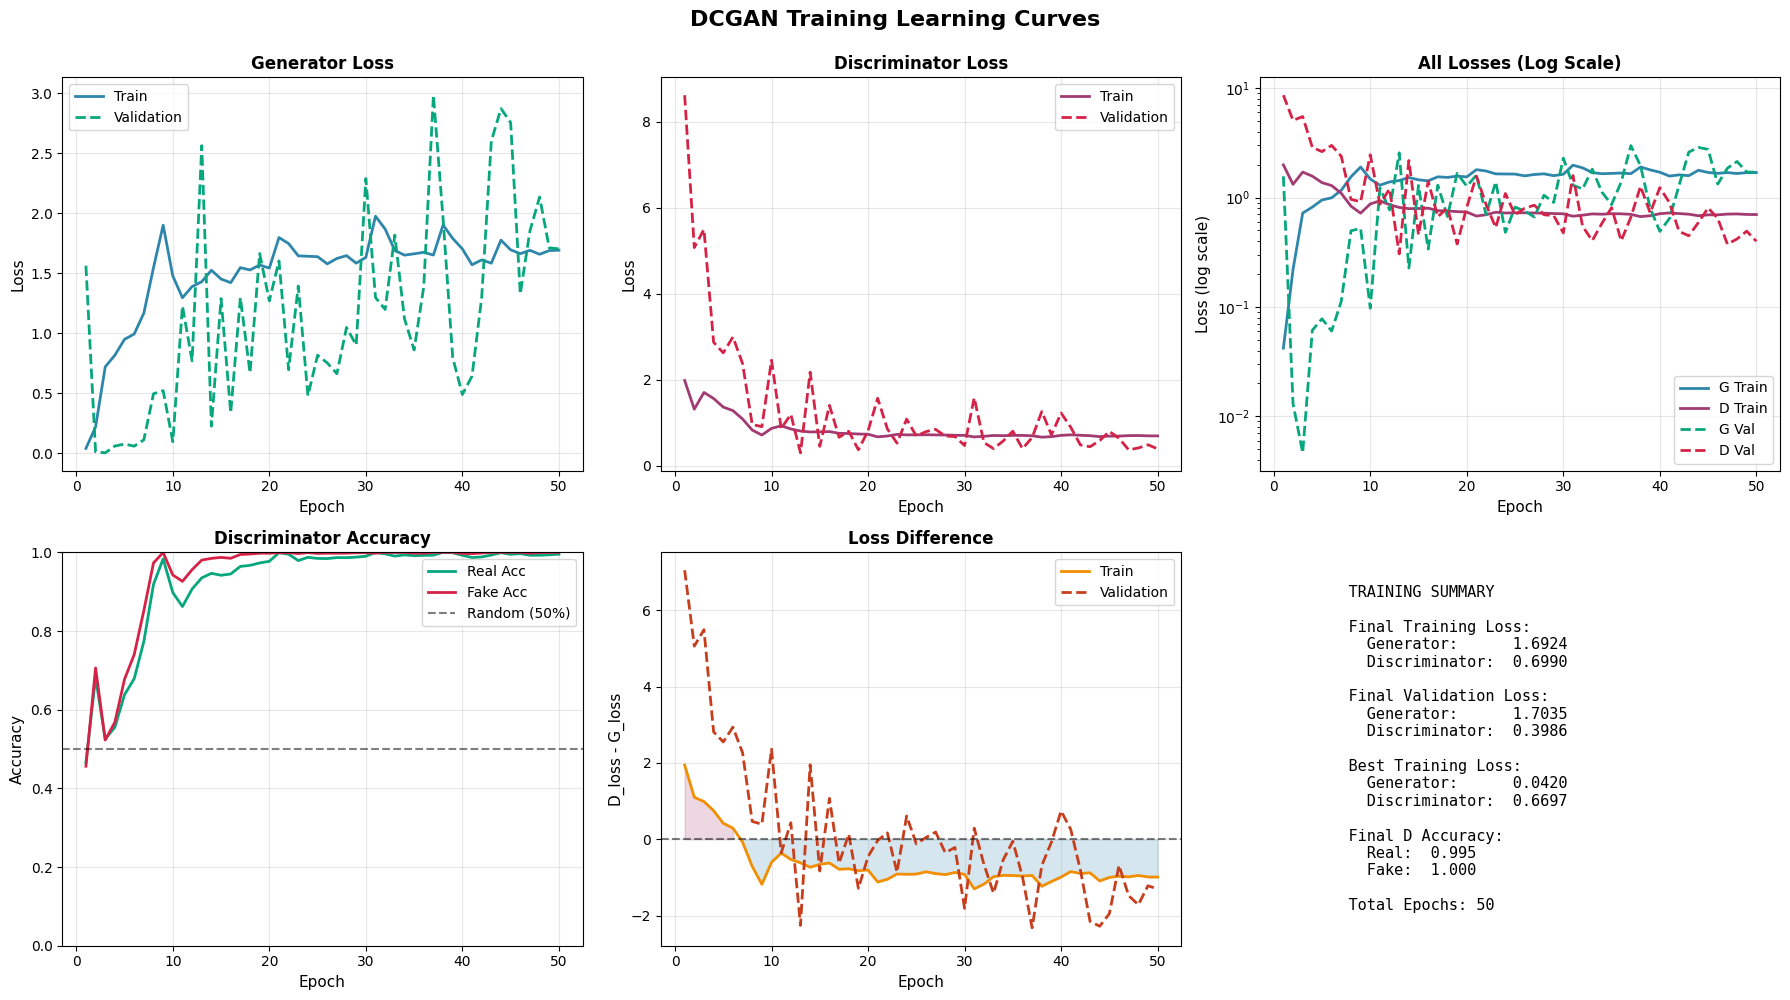

In [18]:
def plot_learning_curves(history):
    """
    Plot training and validation learning curves
    """
    epochs = range(1, len(history['train_g_loss']) + 1)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Generator Loss
    axes[0, 0].plot(epochs, history['train_g_loss'], label='Train', linewidth=2, color='#2E86AB')
    axes[0, 0].plot(epochs, history['val_g_loss'], label='Validation', linewidth=2, color='#06A77D', linestyle='--')
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].set_title('Generator Loss', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Discriminator Loss
    axes[0, 1].plot(epochs, history['train_d_loss'], label='Train', linewidth=2, color='#A23B72')
    axes[0, 1].plot(epochs, history['val_d_loss'], label='Validation', linewidth=2, color='#D62246', linestyle='--')
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Loss', fontsize=11)
    axes[0, 1].set_title('Discriminator Loss', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Both losses (log scale)
    axes[0, 2].semilogy(epochs, history['train_g_loss'], label='G Train', linewidth=2, color='#2E86AB')
    axes[0, 2].semilogy(epochs, history['train_d_loss'], label='D Train', linewidth=2, color='#A23B72')
    axes[0, 2].semilogy(epochs, history['val_g_loss'], label='G Val', linewidth=2, color='#06A77D', linestyle='--')
    axes[0, 2].semilogy(epochs, history['val_d_loss'], label='D Val', linewidth=2, color='#D62246', linestyle='--')
    axes[0, 2].set_xlabel('Epoch', fontsize=11)
    axes[0, 2].set_ylabel('Loss (log scale)', fontsize=11)
    axes[0, 2].set_title('All Losses (Log Scale)', fontsize=12, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Discriminator Accuracy
    axes[1, 0].plot(epochs, history['d_real_acc'], label='Real Acc', linewidth=2, color='#06A77D')
    axes[1, 0].plot(epochs, history['d_fake_acc'], label='Fake Acc', linewidth=2, color='#D62246')
    axes[1, 0].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Random (50%)')
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Accuracy', fontsize=11)
    axes[1, 0].set_title('Discriminator Accuracy', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])

    # Loss Difference
    train_diff = np.array(history['train_d_loss']) - np.array(history['train_g_loss'])
    val_diff = np.array(history['val_d_loss']) - np.array(history['val_g_loss'])
    axes[1, 1].plot(epochs, train_diff, label='Train', linewidth=2, color='#F18F01')
    axes[1, 1].plot(epochs, val_diff, label='Validation', linewidth=2, color='#C73E1D', linestyle='--')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].fill_between(epochs, 0, train_diff, where=(train_diff > 0), alpha=0.2, color='#A23B72')
    axes[1, 1].fill_between(epochs, 0, train_diff, where=(train_diff < 0), alpha=0.2, color='#2E86AB')
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('D_loss - G_loss', fontsize=11)
    axes[1, 1].set_title('Loss Difference', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Training Summary
    axes[1, 2].axis('off')
    summary_text = f"""
    TRAINING SUMMARY

    Final Training Loss:
      Generator:      {history['train_g_loss'][-1]:.4f}
      Discriminator:  {history['train_d_loss'][-1]:.4f}

    Final Validation Loss:
      Generator:      {history['val_g_loss'][-1]:.4f}
      Discriminator:  {history['val_d_loss'][-1]:.4f}

    Best Training Loss:
      Generator:      {min(history['train_g_loss']):.4f}
      Discriminator:  {min(history['train_d_loss']):.4f}

    Final D Accuracy:
      Real:  {history['d_real_acc'][-1]:.3f}
      Fake:  {history['d_fake_acc'][-1]:.3f}

    Total Epochs: {len(history['train_g_loss'])}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                   verticalalignment='center')

    plt.suptitle('DCGAN Training Learning Curves', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot learning curves
plot_learning_curves(history)

# Generate microstructures

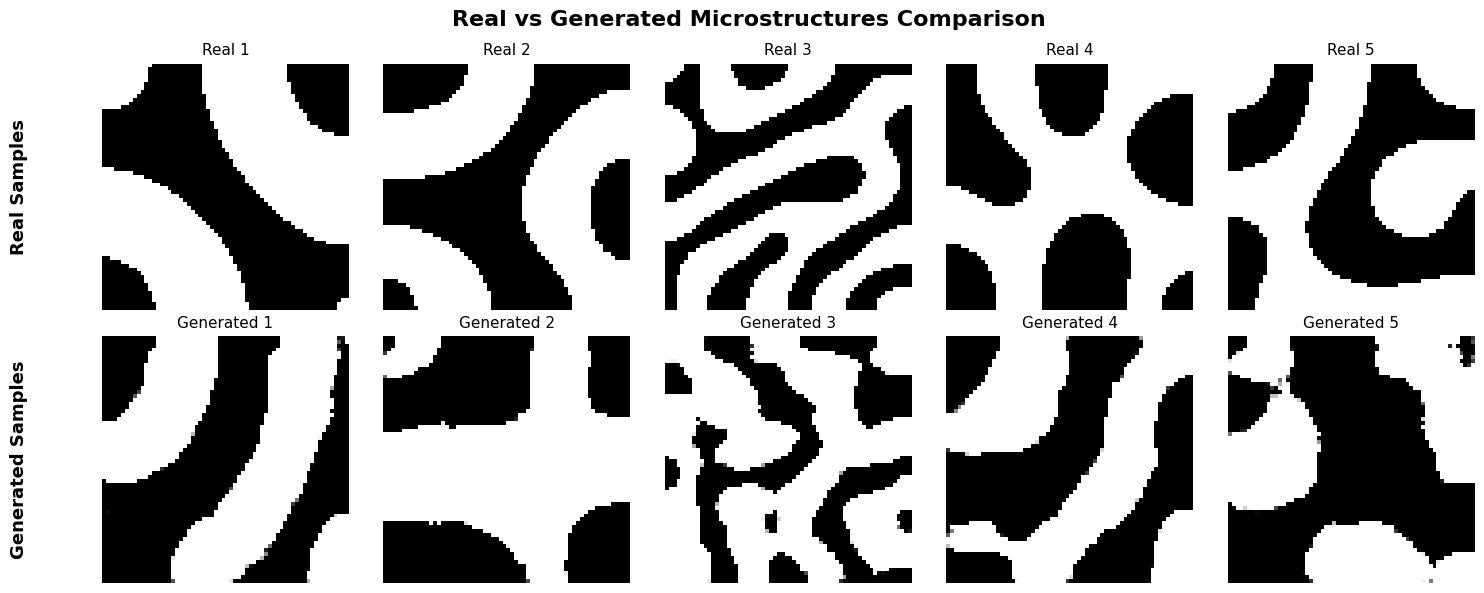

In [51]:
def compare_real_vs_generated(generator, real_samples, num_samples=5):
    """
    Compare real samples with generated samples
    """
    generator.eval()

    # Generate samples
    with torch.no_grad():
        z = torch.randn(num_samples, LATENT_DIM, 1, 1, device=device)
        generated = generator(z).cpu()

    # Denormalize
    real_imgs = (real_samples + 1) / 2
    gen_imgs = (generated + 1) / 2

    # Plot comparison
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        # Real images
        axes[0, i].imshow(real_imgs[i, 0].numpy(), cmap='gray')
        axes[0, i].set_title(f'Real {i+1}', fontsize=11)
        axes[0, i].axis('off')

        # Generated images
        axes[1, i].imshow(gen_imgs[i, 0].numpy(), cmap='gray')
        axes[1, i].set_title(f'Generated {i+1}', fontsize=11)
        axes[1, i].axis('off')

    # Add row labels
    axes[0, 0].text(-0.3, 0.5, 'Real Samples', fontsize=13, fontweight='bold',
                   transform=axes[0, 0].transAxes, rotation=90,
                   verticalalignment='center', horizontalalignment='right')
    axes[1, 0].text(-0.3, 0.5, 'Generated Samples', fontsize=13, fontweight='bold',
                   transform=axes[1, 0].transAxes, rotation=90,
                   verticalalignment='center', horizontalalignment='right')

    plt.suptitle('Real vs Generated Microstructures Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('real_vs_generated_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    generator.train()

# Create comparison
compare_real_vs_generated(generator, real_samples_for_comparison, num_samples=5)

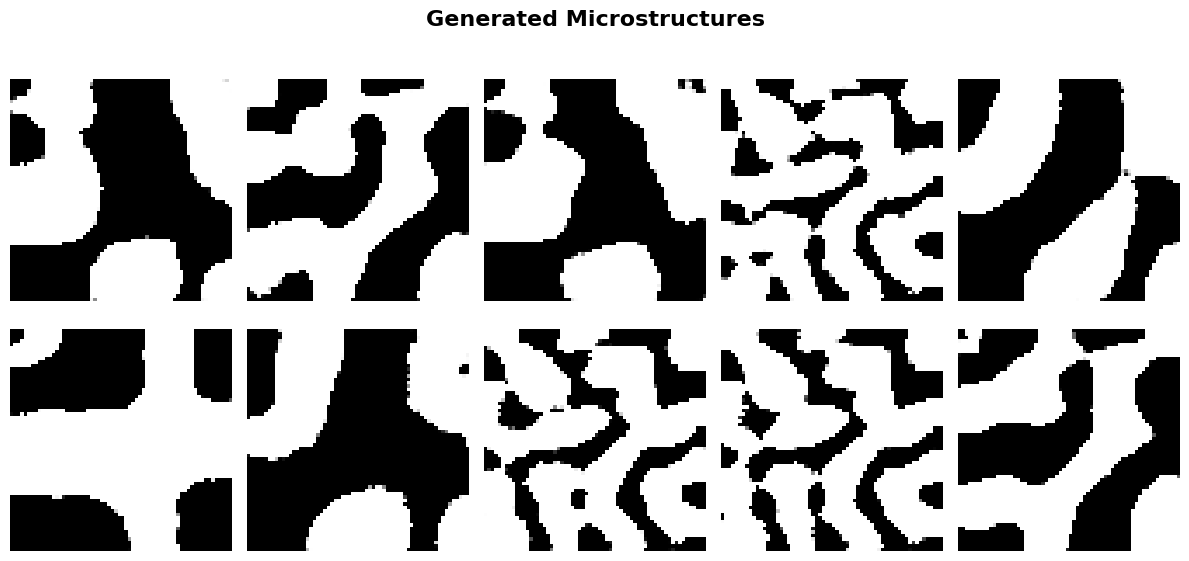

Generated 10 new microstructures


In [66]:
# Generate a grid of new samples
generator.eval()

num_samples = 10
with torch.no_grad():
    z = torch.randn(num_samples, LATENT_DIM, 1, 1, device=device)
    generated = generator(z).cpu()
    generated = (generated + 1) / 2

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i, 0], cmap='gray')
    ax.axis('off')

plt.suptitle('Generated Microstructures', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('generated_samples_grid.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Generated {num_samples} new microstructures')

In [ ]:
# save model
import os
PATH = '/content/drive/MyDrive/Colab Notebooks'
torch.save(model, os.path.join(PATH, f'mech_MNIST_entire.pt'))

# model_scripted = torch.jit.script(model.cpu())
# model_scripted.save(os.path.join(PATH, f'mech_MNIST_scripted.pt'))

In [ ]:
# load trained model
import os
PATH = '/content/drive/MyDrive/Colab Notebooks'
model = torch.load(os.path.join(PATH, f'mech_MNIST_entire.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')